In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.eos import State as StateEoS
from feos_pcsaft.eos import PhaseEquilibrium as PhaseEquilibriumEoS
from feos_pcsaft.dft import *
# from feos_pcsaft.dft import *
# from feos_pcsaft.feos_pcsaft import *
import glob
#import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/home/bursik/anaconda3/envs/entropy_scaling/lib/python3.9/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

In [3]:
components = ['propane']#, 'butane']#, 'pentane']
composition = np.array([0.5, 0.5]) *MOL
temperature = 350.15* KELVIN
pressure = 1 * BAR

In [4]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
eos = PcSaft(params)

In [5]:
if len(components) == 1:
    t_crit = StateEoS.critical_point_pure(eos)[0].temperature
    vleEoS = PhaseEquilibriumEoS.pure_t(eos, temperature)
else:
    t_crit = StateEoS.critical_point(eos, composition).temperature
    vleEoS = PhaseEquilibriumEoS.bubble_point_tx(eos, temperature, composition/MOL)
vleEoS

||temperature|density|
|-|-|-|
|phase 1|350.15000 K|1.67093 kmol/m³|
|phase 2|350.15000 K|8.63013 kmol/m³|


In [6]:
print(vleEoS.liquid.viscosity())
print(vleEoS.vapor.viscosity())


51.04751078248119 µPas
13.185201814441578 µPas


In [7]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
func = PcSaftFunctional(params)
func_hs = (params)

In [8]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|350.15000 K|1.67093 kmol/m³|
|phase 2|350.15000 K|8.63013 kmol/m³|


In [11]:
# PLANAR INTERFACE
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit)

In [10]:
# PORE 1D
potential  = ExternalPotential.LJ93(2.5, 40.0, 0.08)
interface = Pore1D(func, Geometry.Cartesian, 50*ANGSTROM, potential, 512).initialize(vle.liquid)

In [12]:
solver = DFTSolver(output=False).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
density_init = interface.density
interface.solve(solver, debug=False)   

In [13]:
# print(interface.surface_tension)

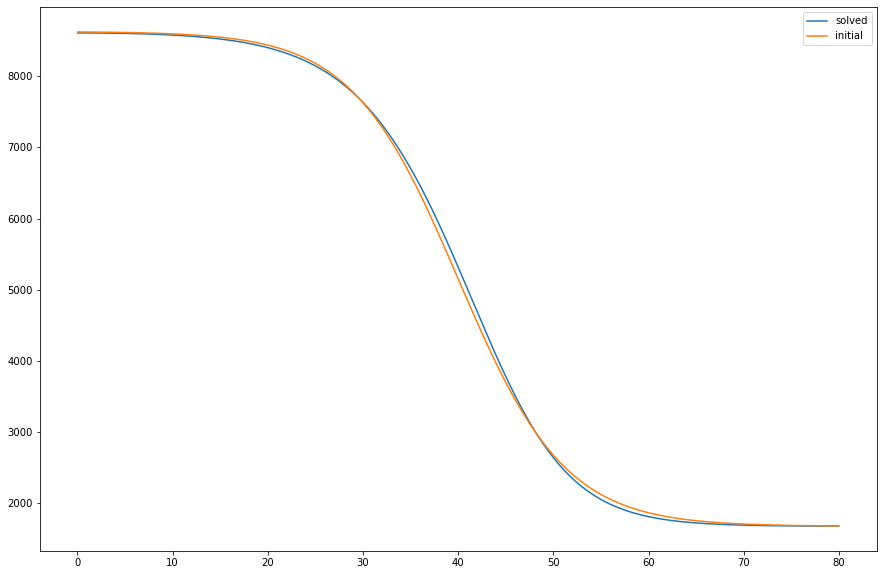

In [14]:
plt.figure(figsize=[15,10])
plt.plot(interface.z/ANGSTROM, (interface.density/MOL*METER**3)[0], label='solved')
plt.plot(interface.z/ANGSTROM, (density_init/MOL*METER**3)[0], label='initial')
plt.legend()

In [15]:
print(interface.viscosity_profile[0])
print(interface.viscosity_profile[-1])

50.827925504596614 µPas
0 in wd_entropy
13.183856523179603 µPas
1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib
0 in wd_entropy
1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib


0 in wd_entropy


1 in wd_entropy
2 in wd_entropy
3 in wd_entropy
0 in edc
1 in edc
2 in edc
3 in edc
0 in entr_contrib
1 in entr_contrib
2 in entr_contrib
3 in entr_contrib


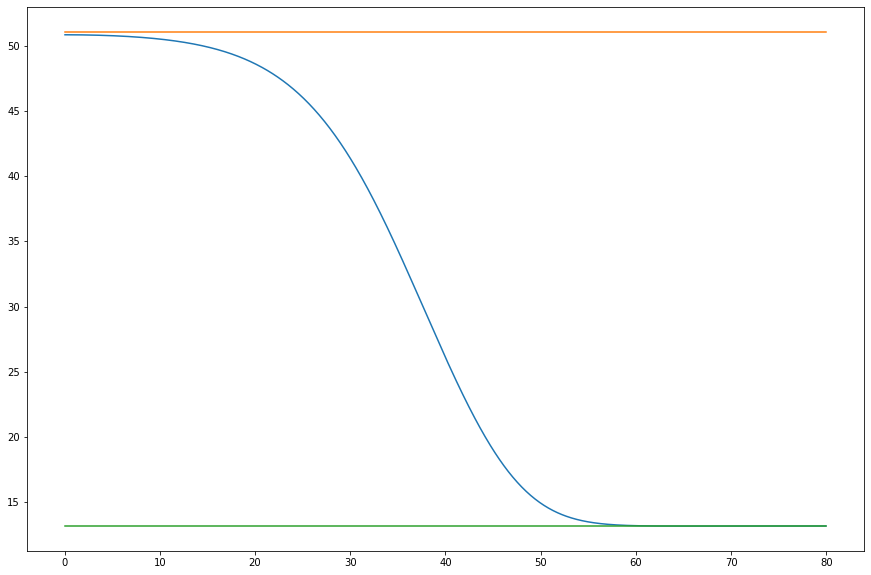

In [16]:
plt.figure(figsize=[15,10])

plt.plot(interface.z/ANGSTROM, interface.viscosity_profile/MICRO/PASCAL/SECOND)
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND, vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND])
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND, vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND])


data shape = (1, 512)
data shape = (1, 512)
data shape = (1, 512)
data shape = (1, 512)


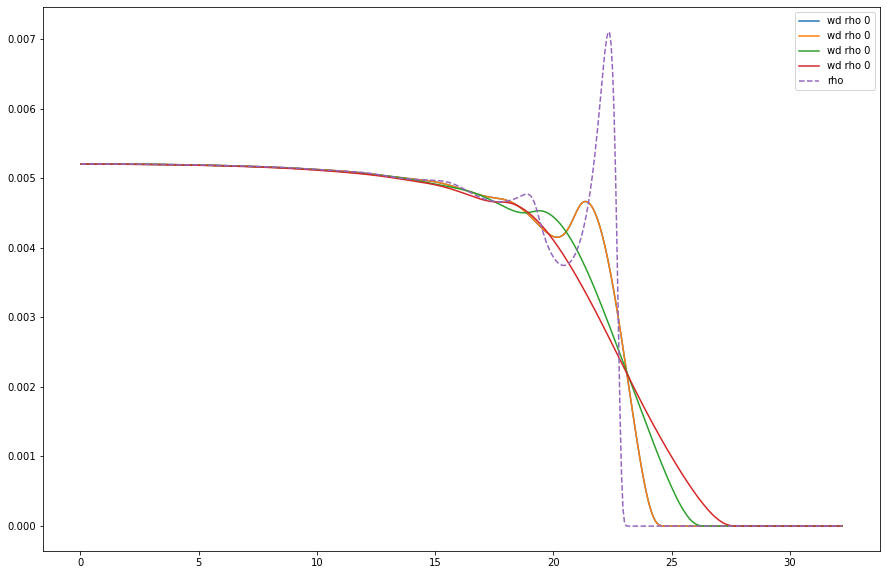

In [84]:
plt.figure(figsize=[15,10])
    
for filename in glob.glob('*wd_entropy.npy'):
    data = np.load(filename)    
    print(f'data shape = {data.shape}')
    for j in range(data.shape[0]):
        plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'wd rho {j}')#, marker = 'x')
        
plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho', linestyle='--')
plt.legend()

In [85]:
len(interface.weighted_densities)

3

data shape = (512,)
data shape = (512,)
data shape = (512,)
data shape = (512,)


Text(0.5, 1.0, 'entropy density for each contribution')

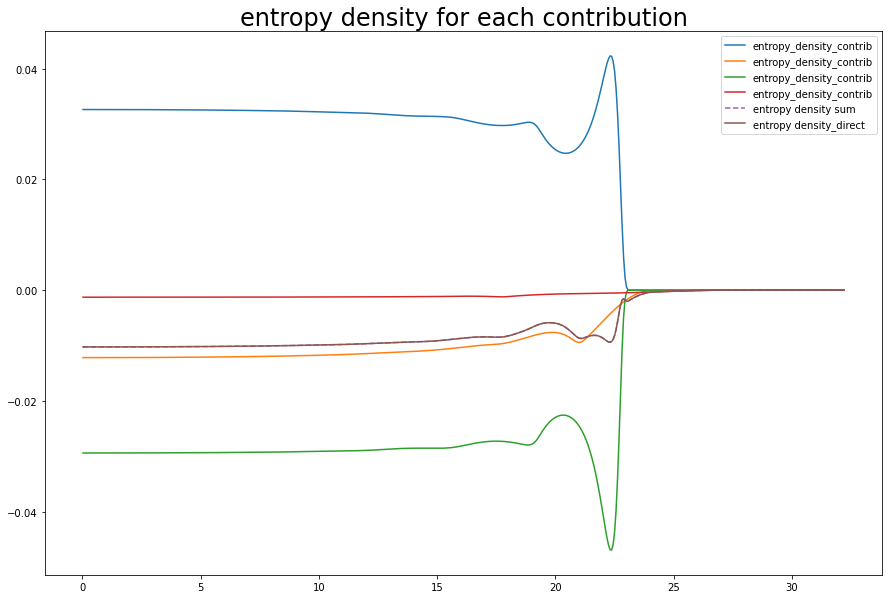

In [86]:
plt.figure(figsize=[15,10])
entropy_density = np.zeros((interface.z/ANGSTROM).shape[0])

for filename in glob.glob('*edc.npy'):
    data = np.load(filename)    
    print(f'data shape = {data.shape}')
    
    plt.plot(interface.z / ANGSTROM, (data), label=f'entropy_density_contrib')#, marker = 'x')
    entropy_density = entropy_density + data
plt.plot(interface.z/ANGSTROM, entropy_density, label='entropy density sum', linestyle='--')
# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/PASCAL/SECOND, label='entropy sum')
plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/RGAS*NAV*ANGSTROM**3, label='entropy density_direct')


# plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho')
plt.legend()
plt.title('entropy density for each contribution', fontsize=24)

Text(0.5, 1.0, 'entropy density divided by corresponding (weighted) density for each contribution')

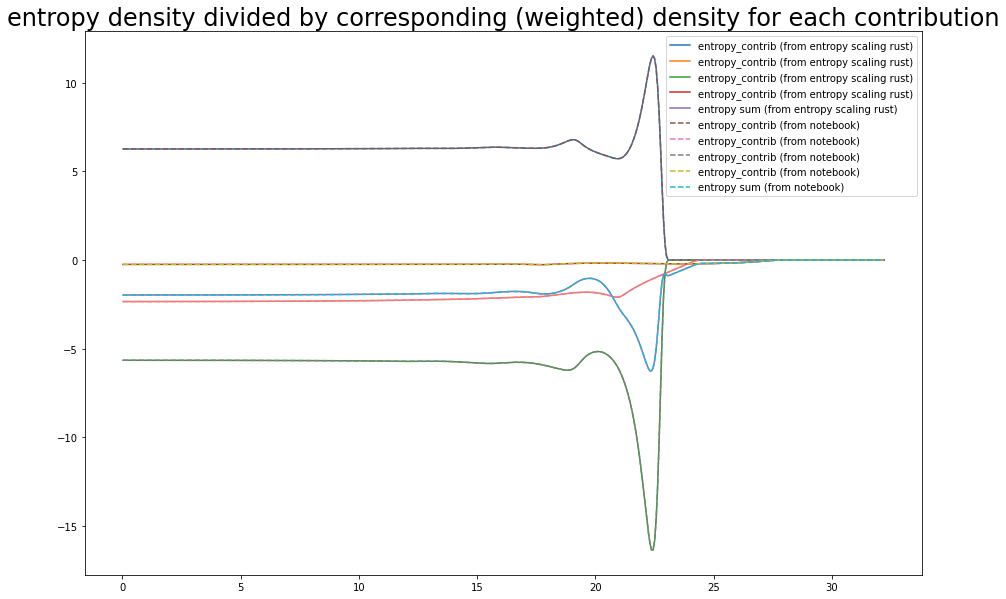

In [89]:
plt.figure(figsize=[15,10])
entropy = np.zeros((interface.z/ANGSTROM).shape[0])

for filename in glob.glob('*entr_contrib.npy'):
    data = np.load(filename)    
    plt.plot(interface.z / ANGSTROM, (data), label=f'entropy_contrib (from entropy scaling rust)')#, marker = 'x')
    entropy = entropy + data
plt.plot(interface.z/ANGSTROM, entropy, label='entropy sum (from entropy scaling rust)')
# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS, label='entropy from regular density')

entropy_notebook = np.zeros((interface.z/ANGSTROM).shape[0])

for (filename_edc, filename_wd) in zip(glob.glob('*edc.npy'), glob.glob('*wd_entropy.npy')):
    data_edc = np.load(filename_edc)   
    data_wd = np.load(filename_wd)[0,:]   
    
    plt.plot(interface.z / ANGSTROM, (data_edc)/data_wd, label=f'entropy_contrib (from notebook)', linestyle='--')#, marker = 'x')
    entropy_notebook = entropy_notebook + data_edc/data_wd
plt.plot(interface.z/ANGSTROM, entropy_notebook, label='entropy sum (from notebook)', linestyle='--')

# entropy_localrho = np.zeros((interface.z/ANGSTROM).shape[0])

# for filename in glob.glob('*_edc.npy'):
#     data = np.load(filename)    
#     plt.plot(interface.z / ANGSTROM, (data)/((interface.density*NAV*ANGSTROM**3)[0,:]), 'k--' ,label=f'entropy_contrib (from local density)')#, marker = 'x')
#     entropy_localrho = entropy_localrho + (data)/((interface.density*NAV*ANGSTROM**3)[0,:])
# plt.plot(interface.z/ANGSTROM, entropy_localrho, 'k--', label='entropy sum (from local density)')

# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS,label='entropy from regular density')

# plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho')
plt.legend()
plt.title('entropy density divided by corresponding (weighted) density for each contribution', fontsize=24)

In [90]:
interface.entropy_density(Contributions.Residual)#/#/KILOGRAM*ANGSTROM*KELVIN*SECOND**2

[-280696.2818272348, -280696.2770860174, -280696.2676001497, -280696.25336277403, -280696.23436363065, ..., -506.2243818496717, -506.2243822568124, -506.22438256096353, -506.2243827628076, -506.2243828628729] m^-1 kg s^-2 K^-1

In [95]:
interface.entropy_density(Contributions.Residual)/((interface.density/MOL*METER**3)[0,:]*MOL/METER**3)

[-25.135041716617977, -25.13504145511071, -25.135040931942292, -25.13504014680662, -25.135039099243787, ..., -1.0996289472213965, -1.099628948967484, -1.0996289502734893, -1.099628951141789, -1.0996289515741486] J/mol/K

In [43]:
interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS

array([-3.02305066, -3.02305063, -3.02305057, ..., -0.13225496,
       -0.13225496, -0.13225496])

In [101]:
entropy

array([-2.6882359 , -2.68823588, -2.68823584, ..., -0.0668435 ,
       -0.06684351, -0.06684351])